In [3]:
from sbi.score.score_net import TimeConditionalScoreNet
from sbi.score.score_sde import VESDE, VPSDE
from sbi.score.score_loss import continuous_denoised_loss

from sbi.vi.build_q import build_q 

#from sbi import pairplot

import sbibm
import torch
import tqdm
#from sbi.analysis import pairplot
import matplotlib.pyplot as plt

In [ ]:
task = sbibm.get_task("gaussian_linear")
prior = task.get_prior_dist()
simulator = task.get_simulator()

thetas = prior.sample((1000,))
xs = simulator(thetas)

C:\Users\manug\miniconda3\lib\site-packages\pyro\distributions\torch_patch.py:82: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torch.linalg.eigvalsh(A, UPLO='U' if upper else 'L')
and
L, V = torch.symeig(A, eigenvectors=True)
should be replaced with
L, V = torch.linalg.eigh(A, UPLO='U' if upper else 'L') (Triggered internally at  ..\aten\src\ATen\native\BatchLinearAlgebra.cpp:2500.)
  for v in flattened_value]).view(batch_shape)


In [10]:
sde = VESDE()
sde.marginal_prob(torch.zeros(10), torch.ones(1)*0.1)

(tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.0234]))

In [6]:
#scorenet = ContinousTimeDenseScoreNet(2, marginal_prob=sde.marginal_prob, context_dim=2)

In [15]:
scorenet = TimeConditionalScoreNet(10, sde.marginal_prob, context_dim=10)

In [16]:
data = [(theta, x) for theta, x in zip(thetas,xs)]
data = torch.utils.data.DataLoader(data, shuffle=True, batch_size=1000)
optimizer = torch.optim.Adam(scorenet.parameters(), lr=1e-3)
epochs = tqdm.tqdm(range(200))
scorenet.train()
for ep in epochs:
    for theta,x in data:
        optimizer.zero_grad()
        loss = continuous_denoised_loss(scorenet, theta, context=x)
        loss.backward()
        optimizer.step()
        epochs.set_description(f"Loss: {loss}")

s]

Loss: 5.036028861999512:  39%|███▉      | 78/200 [00:18<00:37,  3.21it/s]

Loss: 5.036028861999512:  40%|███▉      | 79/200 [00:18<00:35,  3.42it/s]

Loss: 4.885077476501465:  40%|███▉      | 79/200 [00:18<00:35,  3.42it/s]

Loss: 4.885077476501465:  40%|████      | 80/200 [00:18<00:49,  2.44it/s]

Loss: 4.811341285705566:  40%|████      | 80/200 [00:19<00:49,  2.44it/s]

Loss: 4.811341285705566:  40%|████      | 81/200 [00:19<00:43,  2.72it/s]

Loss: 4.748833656311035:  40%|████      | 81/200 [00:19<00:43,  2.72it/s]

Loss: 4.748833656311035:  41%|████      | 82/200 [00:19<00:37,  3.18it/s]

Loss: 4.735045909881592:  41%|████      | 82/200 [00:20<00:37,  3.18it/s]

Loss: 4.735045909881592:  42%|████▏     | 83/200 [00:20<00:50,  2.33it/s]

Loss: 4.92262077331543:  42%|████▏     | 83/200 [00:20<00:50,  2.33it/s] 

Loss: 4.92262077331543:  42%|████▏     | 84/200 [00:20<00:43,  2.69it/s]

Loss: 4.796885967254639:  42%|████▏     | 84/200 [00:20<00:43,  2.69it/s]

Loss: 4.79688596725463

# Score VI

We can minimize the elbo using the score 
$$ \nabla_\phi \mathbb{E}_\epsilon[\log p(x,g_\phi(\epsilon))-\log q_\phi(x,g_\phi(\epsilon))]  =  \mathbb{E}_\epsilon[\nabla_g \log p(x,g_\phi(\epsilon)) \nabla_\phi g_\phi(\epsilon)] - \mathbb{E}_q[\nabla_g \log q_\phi(g_\phi(\epsilon)* \nabla_\phi g_\phi(\epsilon)]$$

As we have a continous score model, we can start learn the noisy posterior, which is rather simple and connects all modes, then slowly anneal to the true values...

In [23]:
q = build_q((10,), prior.support, flow="affine_autoregressive")
_ = scorenet.eval()

In [24]:
optimizer = torch.optim.Adam(q.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.999)
x_obs = task.get_observation(1)
#ts = [1]*10 + [0.5]*20 + [0.1]*30 + [1e-2]*50 + [1e-3]*100 + [1e-5]*200
ts = [0.4]*100
for i in range(100):
    optimizer.zero_grad()
    particles = q.rsample((100,))
    loss_q = torch.mean(q.log_prob(particles))
    loss_p = torch.mean(torch.sum(scorenet(particles, torch.ones(100)*ts[i],
    context=x_obs.repeat(100,1)).detach()*particles,1))
    #loss_p = torch.mean(torch.sum(scorenet(particles, context=x_obs.repeat(100,1)).detach()*particles,1))
    loss = -(loss_p- loss_q)
    loss.backward()
    optimizer.step()
    scheduler.step()

(<Figure size 720x720 with 100 Axes>,
 array([[<AxesSubplot:xlabel='dim 1'>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:xlabel='dim 2'>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:xlabel='dim 3'>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:xlabel='dim 4'>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:xlabel='dim 5'>, <AxesSubplot:>, <AxesSubplot:>,
         <

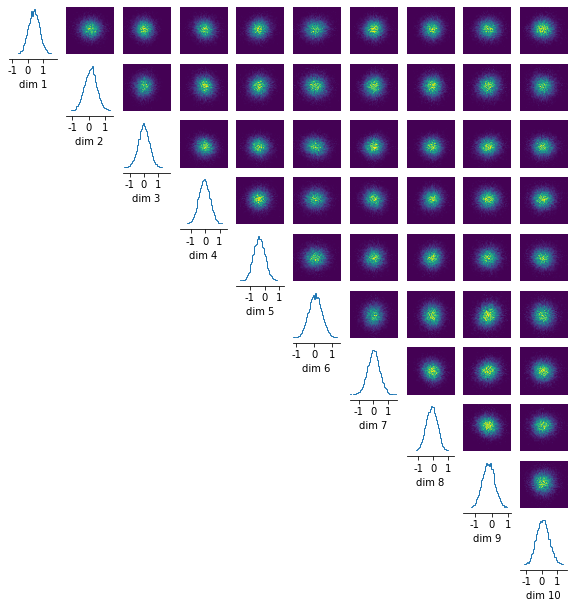

In [25]:
samples = q.sample((10000,))
#plt.hexbin(samples[:,0], samples[:,1])
pairplot(samples)

In [32]:
x_obs = task.get_observation(1)
#ts = [1]*10 + [0.5]*20 + [0.1]*30 + [1e-2]*50 + [1e-3]*100 + [1e-5]*200
ts = [1e-6]*100
for i in range(100):
    optimizer.zero_grad()
    particles = q.rsample((5000,))
    loss_q = q.log_prob(particles)
    score = scorenet(particles, torch.ones(5000)*ts[i], context=x_obs.repeat(5000,1)).detach()
    loss_p = torch.sum(score*particles,1)


    loss = -torch.sum((loss_p- loss_q))
    loss.backward()
    optimizer.step()
    scheduler.step()

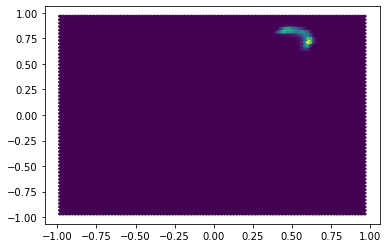

In [10]:
samples = q.sample((10000,))
plt.hexbin(samples[:,0], samples[:,1])

# Using steins identity

$$ \mathbb{E}_q \left[k(\theta, \cdot) \nabla_\theta \log p(\theta|x)^T + \nabla_\theta k(\theta)\right] = 0 $$

As we know the score we can minimize the expecation using the reparamterization trick.

In [31]:
q = build_q((10,), prior.support, flow="affine_autoregressive")
kernel_function = lambda x,y,h=1: torch.exp(-0.5*torch.cdist(x,y)**2/h**2)
scorenet.eval()
score_fn = lambda x, t=torch.ones(len(x))*1e-6: scorenet(x, t,context=x_obs.repeat(x.shape[0],1)) 

In [27]:
x = torch.randn(10,2)
D = x.unsqueeze(1)-x.unsqueeze(0)
#torch.sum(D*x,-1).unsqueeze(-1)*D

In [32]:
def stein_discrepancy(x, h=1):
    score = score_fn(x, t=torch.ones(x.shape[0])*1e-6)
    K = kernel_function(x,x, h=h)
    D = x.unsqueeze(1)-x.unsqueeze(0)
    N = x.shape[0]
    term1 = score@score.T*K 
    term2 = torch.sum((-1/h**2*D*K.unsqueeze(-1))*x, dim=-1)
    term3 = torch.sum((1/h**2*D*K.unsqueeze(-1))*x, dim=-1)
    term4 = torch.sum(-1/h**2*D**2 + 1/h**2, dim=-1)*K
    matrix = term1 + term2 + term3 + term4 
    mask = torch.eye(N).long()
    return 1/(N*(N-1))*torch.sum(matrix[mask])

In [39]:
optimizer = torch.optim.Adam(q.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.999)
x_obs = task.get_observation(1)
for i in range(1000):
    optimizer.zero_grad()
    samples = q.rsample((100,))
    loss = stein_discrepancy(samples, h=0.1)
    loss.backward()
    print(loss)
    optimizer.step()
    scheduler.step()

tensor(85744.6172, grad_fn=<MulBackward0>)
tensor(94757.4062, grad_fn=<MulBackward0>)
tensor(98738.7422, grad_fn=<MulBackward0>)
tensor(94063.9609, grad_fn=<MulBackward0>)
tensor(91261.3125, grad_fn=<MulBackward0>)
tensor(92287.5469, grad_fn=<MulBackward0>)
tensor(110195.6719, grad_fn=<MulBackward0>)
tensor(90366.7031, grad_fn=<MulBackward0>)
tensor(87079.2656, grad_fn=<MulBackward0>)
tensor(87576.8047, grad_fn=<MulBackward0>)
tensor(88619.6016, grad_fn=<MulBackward0>)
tensor(89822.1797, grad_fn=<MulBackward0>)
tensor(89624.7109, grad_fn=<MulBackward0>)
tensor(93168.6953, grad_fn=<MulBackward0>)
tensor(89935.6172, grad_fn=<MulBackward0>)
tensor(90019.4531, grad_fn=<MulBackward0>)
tensor(100502.6797, grad_fn=<MulBackward0>)
tensor(88827.2188, grad_fn=<MulBackward0>)
tensor(90518.6328, grad_fn=<MulBackward0>)
tensor(90689.7344, grad_fn=<MulBackward0>)
tensor(88153.5547, grad_fn=<MulBackward0>)
tensor(96014.8672, grad_fn=<MulBackward0>)
tensor(100233.7812, grad_fn=<MulBackward0>)
tensor(7

KeyboardInterrupt: 

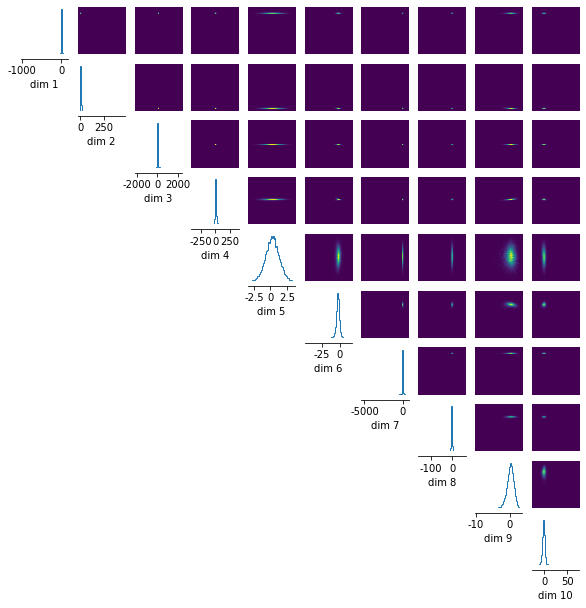

In [40]:
samples = q.sample((10000,))
#plt.hexbin(samples[:,0], samples[:,1])
_ = pairplot(samples)

In [23]:
particles = prior.sample((10000,))
def stein_vi_update(x, h=0.01, eps=1e-2):
    N = len(x)
    dlogp = scorenet(x, torch.ones(N)*1e-5, context=x_obs.repeat(N,1)).detach()
    K = kernel_function(x,x, h=h)
    dK = -K@x 
    sumK = K.sum(1)
    for i in range(x.shape[1]):
        dK[:,i] = dK[:,i] + x[:,i]*sumK 
    dK /= h**2

    phi_x = 1/N*(K@dlogp + dK)
    x = x + eps*phi_x
    return x

In [145]:
optimizer = torch.optim.Adam(q.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.999)
x_obs = task.get_observation(1)
for i in range(1000):
    optimizer.zero_grad()
    idx = torch.randint(1000,(50,))
    x = particles[idx]
    x = stein_vi_update(x)
    particles[idx] = x
    loss = -q.log_prob(x).sum()
    loss.backward()
    optimizer.step()
    scheduler.step()

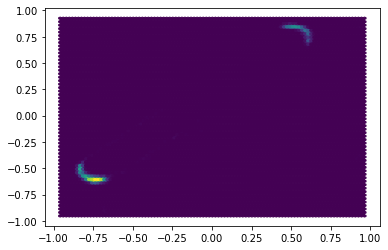

In [146]:
samples = q.sample((10000,))
plt.hexbin(samples[:,0], samples[:,1])